#### Python Libraries Used

In [2]:
import re
import cv2
import nltk
import json
import keras
import pickle
import string
import collections
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.layers.merge import add
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

Using TensorFlow backend.


## Text Preprocessing

#### Read Text Captions

In [2]:
# Reading text Captions from the file
def Read_Text_File(path):
    with open(path) as f:
        captions = f.read()
    return captions

path = "Data/Flickr_Text_Data/Flickr8k.token.txt"
captions = Read_Text_File(path)
captions = captions.split("\n")[:-1]      # Splitting and Removing Last line as it is empty
print(len(captions))
captions[0]

40460


'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

#### Dictionary to map each Image with the list of Captions Below it

In [3]:
descriptions = {}

for x in captions:
    first, second = x.split("\t")      # split among the tab
    image_name = first.split(".")[0]       # extracting the image_name 
    
    if descriptions.get(image_name) is None:     # If image id is not present then create 
        descriptions[image_name] = []            # an empty dictionary and append all the                
    descriptions[image_name].append(second)      # 5 descriptions to it.
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

#### Data Cleaning and Storing

In [6]:
def Clean_Captions(sentence):
    sentence = sentence.lower()  # Converting all sentences to lowercase
    sentence = re.sub("[^a-z]+", " ", sentence)   # Removing all the Punctuation marks and digits
    sentence = sentence.split()   # tokenize
    sentence = [s for s in sentence if len(s) > 1]    # For removing words of single length
    sentence = " ".join(sentence)
    return sentence
print(Clean_Captions("A cat is sitting over the house number 64"))

for key, caption_list in descriptions.items():     # Doing cleaning for every sentence
    for i in range(len(caption_list)):
        caption_list[i] = Clean_Captions(caption_list[i])
print(descriptions["2506892928_7e79bec613"])

# Write the cleaned captions in a file
with open("descriptions.txt", "w") as f:
    f.write(str(descriptions))

cat is sitting over the house number
['three children in field with white flowers', 'three children one with stuffed kitten in field of flowers', 'three children play in the garden', 'three children pose among wildflowers', 'three kids palying with toy cat in garden']


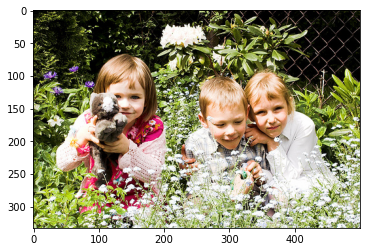

In [7]:
# how the images looks like
image_path = "Data/Images/"
image = cv2.imread(image_path + "2506892928_7e79bec613.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

#### Creating Vocab

In [8]:
descriptions = None
# loading of file
with open("descriptions.txt") as f:
    descriptions = f.read()

# converting into json format to convert the type of descriptions from string to dicttionary
json_acceptable = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable)
# print(descriptions)

# creating vocabulary
vocab = set()   # set is used to eliminate the elements occuring more than once
for key in descriptions.keys():
    for sentence in descriptions[key]:
        vocab.update(sentence.split())    # adding elements to a set
print(f"Vocab Size: {len(vocab)}")

# total number of words
total_words = []
for key in descriptions.keys():
    for des in descriptions[key]:
        for word in des.split():
            total_words.append(word)
print(f"Total No Of Words: {len(total_words)}")
# print(total_words[:100])

Vocab Size: 8424
Total No Of Words: 373837


#### Filtering Words from the vocab according to certain Threshold Frequency (6)

In [13]:
counter = collections.Counter(total_words)
freq_count = dict(counter)
# print(len(freq_count.keys()))

# sorting according to the number of occurences
sorted_freq_count = sorted(freq_count.items(), reverse = True, key = lambda x:x[1]) 
# print(sorted_freq_count)

threshold = 6

threshold_freq_count = []
for i in sorted_freq_count:
    if(i[1] > threshold):
        threshold_freq_count.append(i)
        
total_threshold_words = []
for i in threshold_freq_count:
    total_threshold_words.append(i[0])
# print(threshold_freq_count)
print(len(total_threshold_words))

# 3,70,000 -> 8,400 -> 2,400 words

2422


#### Prepare Train/Test Data

In [15]:
train_file_data = Read_Text_File("Data/Flickr_Text_Data/Flickr_8k.trainImages.txt")
test_file_data = Read_Text_File("Data/Flickr_Text_Data/Flickr_8k.testImages.txt")

train = []
for row in train_file_data.split("\n")[:-1]:
    train.append(row.split(".")[0])
    
test = []
for row in test_file_data.split("\n")[:-1]:
    test.append(row.split(".")[0])
    
print(train[:5])
print(test[:5])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']
['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01']


#### Preparing Descriptions for the Training Data 

In [18]:
# Adding <s> and <e> to our training descriptions
train_descriptions = {}

for image_id in train:
    train_descriptions[image_id] = []
    for cap in descriptions[image_id]:
        caption_to_append = "<s> " + cap + " <e>"
        train_descriptions[image_id].append(caption_to_append)
train_descriptions["2506892928_7e79bec613"]

['<s> three children in field with white flowers <e>',
 '<s> three children one with stuffed kitten in field of flowers <e>',
 '<s> three children play in the garden <e>',
 '<s> three children pose among wildflowers <e>',
 '<s> three kids palying with toy cat in garden <e>']

## Transfer Learning

#### Image Preprocessing

In [21]:
model = ResNet50(weights = "imagenet", input_shape = (224, 224, 3))
model.summary()

102858752/102853048 [==============================] - 77s 1us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_______________________

In [28]:
new_model = Model(model.input, model.layers[-2].output)    # Get the output from the 2nd last layer of Resnet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


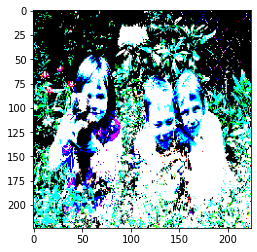

In [35]:
def Preprocess_Images(img):
    img = image.load_img(img, target_size = (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)    # For inputting the batch_size as resnet takes 4d image
    img = preprocess_input(img)    # Normalising Image 
    return img

img = Preprocess_Images("Data/Images/2506892928_7e79bec613.jpg")
plt.imshow(img[0])
plt.show()

In [31]:
def Encode_Images(img):
    img = Preprocess_Images(img)
    feature_vector = new_model.predict(img)   # getting the feature_vector from resnet second last layer
    feature_vector = feature_vector.reshape((-1,))   # reshaping
    # print(feature_vector.shape)
    return feature_vector

Encode_Images("Data/Images/2506892928_7e79bec613" + ".jpg")

array([1.3544536 , 0.6499457 , 0.29071823, ..., 0.        , 0.9668459 ,
       0.38129604], dtype=float32)

#### Images to Features using Resnet50

In [32]:
start_time = time()
encoding_train_images = {}
for idx, image_id in enumerate(train):    # encoding all images to feature vectors
    image_path = "Data/Images/" + image_id + ".jpg"
    encoding_train_images[image_id] = Encode_Images(image_path)

    if(idx % 100 == 0):
        print(f"Progress: {idx}")
end_time = time()
print(f"Total time taken: {end_time - start_time}")

Progress: 0
Progress: 100
Progress: 200
Progress: 300
Progress: 400
Progress: 500
Progress: 600
Progress: 700
Progress: 800
Progress: 900
Progress: 1000
Progress: 1100
Progress: 1200
Progress: 1300
Progress: 1400
Progress: 1500
Progress: 1600
Progress: 1700
Progress: 1800
Progress: 1900
Progress: 2000
Progress: 2100
Progress: 2200
Progress: 2300
Progress: 2400
Progress: 2500
Progress: 2600
Progress: 2700
Progress: 2800
Progress: 2900
Progress: 3000
Progress: 3100
Progress: 3200
Progress: 3300
Progress: 3400
Progress: 3500
Progress: 3600
Progress: 3700
Progress: 3800
Progress: 3900
Progress: 4000
Progress: 4100
Progress: 4200
Progress: 4300
Progress: 4400
Progress: 4500
Progress: 4600
Progress: 4700
Progress: 4800
Progress: 4900
Progress: 5000
Progress: 5100
Progress: 5200
Progress: 5300
Progress: 5400
Progress: 5500
Progress: 5600
Progress: 5700
Progress: 5800
Progress: 5900
Total time taken: 1121.7854628562927


In [33]:
start_time = time()
encoding_test_images = {}
for idx, image_id in enumerate(test):
    image_path = "Data/Images/" + image_id + ".jpg"
    encoding_test_images[image_id] = Encode_Images(image_path)

    if(idx % 100 == 0):
        print(f"Progress: {idx}")
end_time = time()
print(f"Total time taken: {end_time - start_time}")

Progress: 0
Progress: 100
Progress: 200
Progress: 300
Progress: 400
Progress: 500
Progress: 600
Progress: 700
Progress: 800
Progress: 900
Total time taken: 164.48160576820374


#### Saving Features of Trained Images

In [34]:
with open("Encoded_Train_Features.pkl", "wb") as f:
    pickle.dump(encoding_train_images, f)
    
with open("Encoded_Test_Features.pkl", "wb") as f:
    pickle.dump(encoding_test_images, f)


In [8]:
# loading the saved feature vectors into RAM
with open("Encoded_Train_Features.pkl", "rb") as f:
    encoding_train_images = pickle.load(f)
    
with open("Encoded_Test_Features.pkl", "rb") as f:
    encoding_test_images = pickle.load(f)

#### Captions Preprocessing

In [39]:
print(len(total_threshold_words))
words_to_index = {}
index_to_words = {}
for i, word in enumerate(total_threshold_words):
    words_to_index[word] = i+1
    index_to_words[i+1] = word
print(len(index_to_words))

words_to_index["<s>"] = 2423
index_to_words[2423] = "<s>"

words_to_index["<e>"] = 2424
index_to_words[2424] = "<e>"

vocab_size = len(words_to_index) + 1
print(vocab_size)

# Calculating the max length of the caption in the whole dataset
max_length = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_length = max(max_length, len(cap.split()))
print(max_length)

2422
2422
2425
35


In [40]:
# storing the files in the system
with open("words_to_index.pkl","wb") as f:
    pickle.dump(words_to_index,f)
    
with open("index_to_words.pkl","wb") as f:
    pickle.dump(index_to_words,f)

#### Custom Data Loader (Generator)

In [41]:
def data_loader(train_descriptions, encoding_train_images, words_to_index, max_length, batch_size):
    X1, X2, Y = [], [], []
    
    n = 0
    while True:
        for key, des_list in train_descriptions.items():
            n += 1
            photo = encoding_train_images[key]
            for desc in des_list:
                sequence = []
                for word in desc.split():
                    if(word in words_to_index):
                        sequence.append(words_to_index[word])
                for i in range(1, len(sequence)):
                    xi = sequence[0:i]
                    yi = sequence[i]
                    
                    xi = pad_sequences([xi], maxlen = max_length, value = 0, padding = 'post')[0]
                    yi = to_categorical([yi], num_classes = vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    Y.append(yi)
                
                if(n == batch_size):
                    yield [[np.array(X1), np.array(X2)], np.array(Y)]
                    
                    X1, X2, Y = [], [], []
                    n = 0

#### Word Embeddings

In [42]:
f = open("glove.6B.100d.txt", encoding = "utf-8")

In [43]:
embedding_index = {}

for line in f:
    values = line.split()
#     print(values)
    word = values[0]
    embedded_word = np.array(values[1:], dtype = "float")
    embedding_index[word] = embedded_word

In [44]:
# embedding_index["cat"]

In [45]:
def get_embedding_matrix():
    emb_dim = 100
    matrix = np.zeros((vocab_size, emb_dim))
    for word, index in words_to_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            matrix[index] = embedding_vector
    return matrix

In [46]:
embedded_matrix = get_embedding_matrix()
# embedded_matrix.shape

#### Model Architecture

In [47]:
# Images as Input
input_image_features = Input(shape = (2048,))
input_image_1 = Dropout(0.25)(input_image_features)
input_image_2 = Dense(256, activation = "relu")(input_image_1)

In [48]:
# Captions as Input
input_captions = Input(shape = (max_length,))
input_caption_1 = Embedding(input_dim = vocab_size, output_dim = 100, mask_zero = True)(input_captions)
input_caption_2 = Dropout(0.25)(input_caption_1)
input_caption_3 = LSTM(256)(input_caption_2)

In [49]:
decoder_1 = add([input_image_2, input_caption_3])
decoder_2 = Dense(256, activation = "relu")(decoder_1)
outputs = Dense(vocab_size, activation = "softmax")(decoder_2)

# Combined Model
model = Model(inputs = [input_image_features, input_captions], outputs = outputs)



In [50]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 100)      242500      input_5[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [51]:
model.layers[2].set_weights([embedded_matrix])
model.layers[2].trainable = False

In [52]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam")

#### Training of Model

In [53]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

for i in range(epochs):
    generator = data_loader(train_descriptions, encoding_train_images, words_to_index, max_length, batch_size)
    model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    model.save("Model_3_Weights/model_" + str(i) + ".h5")
    

Epoch 1/1
2000/2000 [==============================] - 541s 271ms/step - loss: 4.2352
Epoch 1/1
2000/2000 [==============================] - 467s 233ms/step - loss: 3.4766
Epoch 1/1
2000/2000 [==============================] - 565s 282ms/step - loss: 3.2166
Epoch 1/1
2000/2000 [==============================] - 472s 236ms/step - loss: 3.0484
Epoch 1/1
2000/2000 [==============================] - 470s 235ms/step - loss: 2.9268
Epoch 1/1
2000/2000 [==============================] - 466s 233ms/step - loss: 2.8315
Epoch 1/1
2000/2000 [==============================] - 545s 273ms/step - loss: 2.7552
Epoch 1/1
2000/2000 [==============================] - 506s 253ms/step - loss: 2.6881
Epoch 1/1
2000/2000 [==============================] - 467s 234ms/step - loss: 2.6364
Epoch 1/1
2000/2000 [==============================] - 469s 235ms/step - loss: 2.5934
Epoch 1/1
2000/2000 [==============================] - 563s 281ms/step - loss: 2.5544
Epoch 1/1
2000/2000 [==============================] -

In [4]:
model = load_model("Model_3_Weights/model_19.h5")

In [5]:
with open("Model_3_index_words/words_to_index.pkl", "rb") as f:
    words_to_index = pickle.load(f)
    
with open("Model_3_index_words/index_to_words.pkl", "rb") as f:
    index_to_words = pickle.load(f)

In [6]:
def predict_caption(photo):
    max_length = 35
    in_text = "<s>"
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence],maxlen=max_length,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = index_to_words[ypred]
        in_text += (' ' + word)
        
        if word == "<e>":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

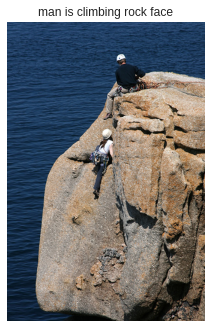

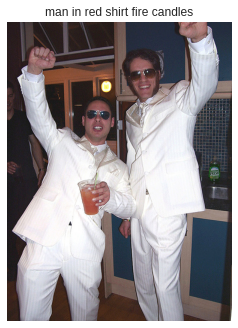

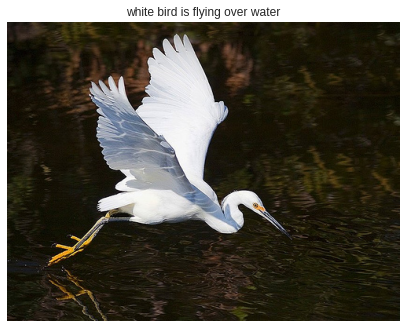

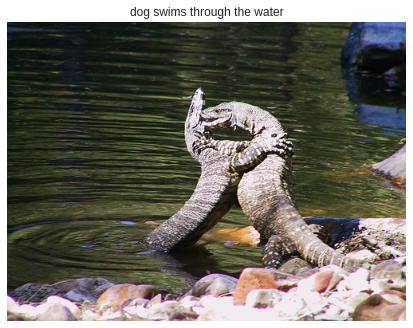

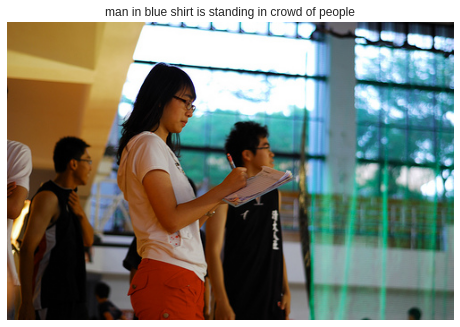

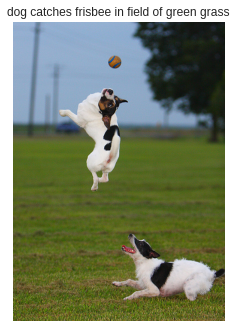

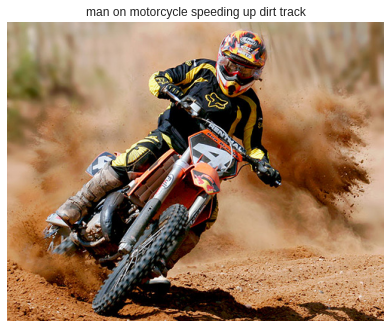

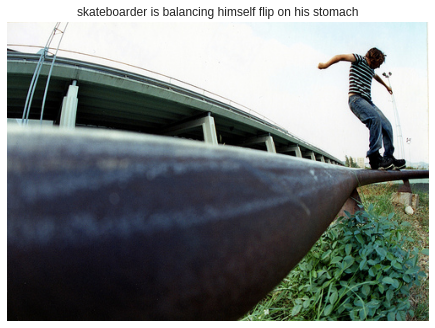

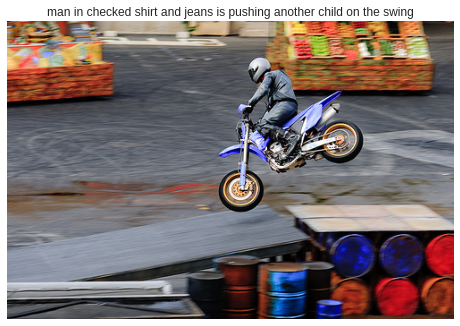

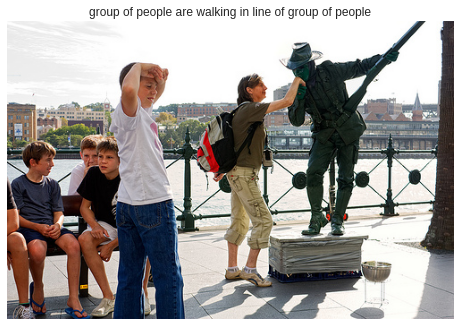

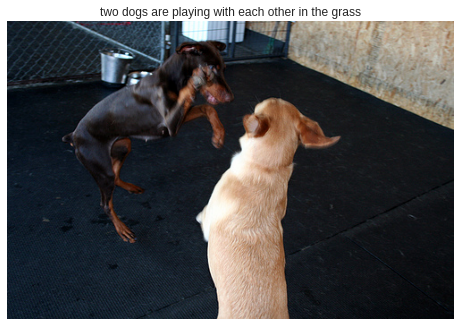

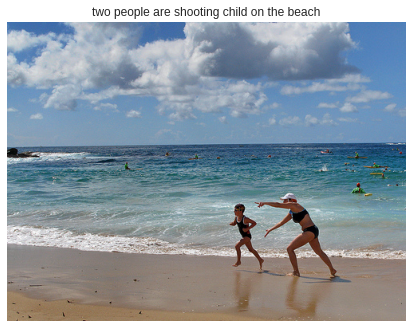

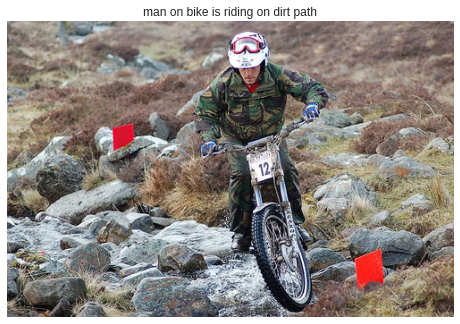

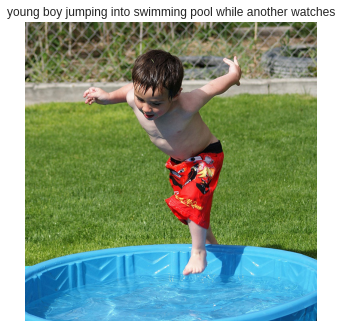

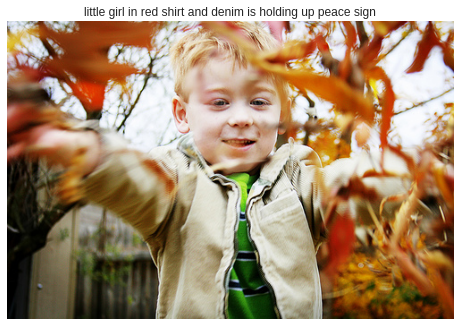

In [10]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test_images.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test_images[img_name].reshape((1,2048))
    
    i = plt.imread("Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    